## Relative Momentum Trading Strategy
參考[How to Create a Relative Momentum Trading Strategy in Python](https://www.the905guy.ca/article/how-to-create-a-relative-momentum-trading-strategy-in-python?fbclid=IwAR1fX2udgpI2SJ9omlEyK81nQJgmFMQVU4XfRzbbG7hFCrPVgYcLP4YARXc)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import fix_yahoo_finance as yf

/home/alia880801/anaconda3/envs/aa/lib/python3.7/site-packages/fix_yahoo_finance/__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



In [2]:
# org_etfs = ['ITOT', 'VEU', 'VNQ', 'AGG']#經典
# org_etfs = ['IOO', 'IJS', 'VNQ', 'AGG']#總體經濟
# org_etfs = ['ITOT', 'VEU', 'BWX', 'AGG']#全球市場
# org_etfs = ['DVY', 'PID', 'LQD', 'PFF']#追求收益
# org_etfs = ['FLOT', 'IOO', 'VNQ', 'TIP']#抗通膨
# org_etfs = ['DSI', 'TSORX', 'TSBRX', 'BAB']#追求永續
# org_etfs = ['V', 'JNJ', 'PG', 'BAC','MA','CVX','ABBV','VZ','UPS','BMY','AXP','MMC','SNOW','MCO','BK','KR','DVA','FND','GL','RH']#巴郡
# org_etfs = ['VTI','VEA','EEM','TLT','TIP','VNQ']#耶魯 斯文森 'IVV','SPY','EFA','IEFA','VWO','IEMG',
# org_etfs = ['VTI','TLT','IEF','GLD','DBC']#全天候 vv
# org_etfs = ['VTI','TLT','BIL','GLD']#永久

In [3]:
# comb = ['ITOT', 'VEU', 'VNQ', 'AGG']
comb = ['VTI','VEA','EEM','TLT','TIP','IVV','SPY','EFA','IEFA','VWO','IEMG','VNQ']

start_date = '2016-01-01'
end_date = '2021-01-01'

mom_period = 10 #126
rebal_freq = 1 #22

num_long = 6
num_short = 0 #3

In [4]:
def my_modulo(a, b):
    while a >= b:
        a -= b
    return a

In [5]:
def relative_momentum(comb,start_date,end_date,mom_period,rebal_freq,num_long,num_short):
    price_df = yf.download(comb, start=start_date, end=end_date)
    my_df = price_df['Close']
    my_df_pct = my_df.pct_change(mom_period)
    my_df_pct = my_df_pct[mom_period:]
    my_df_ranks = pd.DataFrame(columns=my_df_pct.columns, index=my_df_pct.index)

    for i in range(len(my_df_pct)):
        if i % rebal_freq == 0:
            my_df_ranks.iloc[i] = my_df_pct.iloc[i].rank(axis=0, ascending=False)

    my_df_ranks = my_df_ranks.shift(periods=1, axis=0)
    my_df_ranks.ffill(inplace=True)

    num_stocks = my_df_ranks.shape[1] - num_short + 1

    for col in my_df_ranks.columns:
        # if a stock has a rank in the top num_long values, we go long
        my_df_ranks.loc[my_df_ranks[col] <= num_long, col] = 1
        # if a stock has a rank in the bottom num_short values, we go short
        my_df_ranks.loc[my_df_ranks[col] >= num_stocks, col] = -1
        # if a stock doesn't have a ranking in top or bottom n values, we have no position
        my_df_ranks.loc[(my_df_ranks[col] < num_stocks) & (my_df_ranks[col] > num_long), col] = None


    mult_df = (my_df.pct_change()) * my_df_ranks
    mult_df['Total Return'] = (mult_df.sum(axis=1, skipna=True)) / (num_long + num_short)
    mult_df = mult_df[mom_period:]

    # Take the Daily Return of the strategy and computer the growth of strategy in $
    mult_df['Portfolio Value'] = ((mult_df['Total Return'] + 1).cumprod()) * 10000

    return mult_df

In [6]:
mult_df = relative_momentum(comb,start_date,end_date,mom_period,rebal_freq,num_long,num_short)
mult_df

[*********************100%***********************]  12 of 12 completed


,EEM,EFA,IEFA,IEMG,IVV,SPY,TIP,TLT,VEA,VNQ,VTI,VWO,Total Return,Portfolio Value
Date,,,,,,,,,,,,,,
2016-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,10000.000000
2016-01-19,NaN,NaN,NaN,NaN,0.000530,0.001331,-0.000998,-0.003101,NaN,0.005293,-0.001048,NaN,0.000335,10003.345468
2016-01-20,NaN,NaN,NaN,NaN,-0.011597,-0.012815,0.000545,0.010530,-0.022896,-0.026853,NaN,NaN,-0.010514,9898.165902
2016-01-21,NaN,NaN,NaN,NaN,0.005197,0.005602,-0.003630,-0.006789,NaN,0.005546,0.003919,NaN,0.001641,9914.406213
2016-01-22,NaN,NaN,NaN,NaN,0.020627,0.020515,0.001457,-0.003815,0.028994,NaN,0.021310,NaN,0.014848,10061.616821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,NaN,NaN,0.000729,NaN,NaN,0.003890,0.000393,NaN,0.002572,NaN,-0.002380,-0.005691,-0.000081,14128.192053
2020-12-28,NaN,NaN,0.007727,NaN,0.008695,0.008591,0.000707,NaN,0.006201,NaN,0.006327,NaN,0.006375,14218.255269
2020-12-29,NaN,0.006443,0.006944,NaN,-0.001928,-0.001908,NaN,NaN,0.007862,NaN,-0.004174,NaN,0.002207,14249.629546


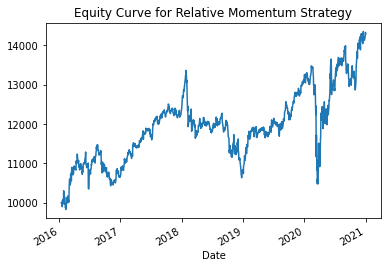

In [7]:
mult_df['Portfolio Value'].plot()
plt.title('Equity Curve for Relative Momentum Strategy')
plt.show()

## Mean Reversion
參考[A Simple Mean Reversion System in Simple Python Code](https://gist.github.com/AnthonyFJGarner/ccd23f0e9d46214612f59c7b92a82149?fbclid=IwAR009-5uFVZAMK2klvNQWrCA8Le7FX9sULY8YA1nLz0KMkb0_kzZRi7oaJs)

### Mean Reversion - Portfolio

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# %matplotlib notebook
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import fix_yahoo_finance as yf
#because the is_list_like is moved to pandas.api.types
pd.core.common.is_list_like = pd.api.types.is_list_like
import ffn

In [8]:
def trade(stock, length):

    temp_dict = {}
    # If window length is 0, algorithm doesn't make sense, so exit
    if length == 0:
        return 0

    # Compute rolling means and rolling standard deviation
    #sma and lma are filters to prevent taking long or short positions against the longer term trend
    rolling_window = stock.Adj_Close.rolling(window=length)
    mu = rolling_window.mean()
    sma = stock.Adj_Close.rolling(window=length*1).mean()
    lma = stock.Adj_Close.rolling(window=length * 10).mean()
    std = rolling_window.std()

    #If you don't use a maximum position size the positions will keep on pyramidding.
    #Set max_position to a high number (1000?) to disable this parameter
    #Need to beware of unintended leverage
    max_position = 1
    percent_per_trade = 1.0

    #Slippage and commission adjustment  - simply reduces equity by a percentage guess
    # a setting of 1 means no slippage, a setting of 0.999 gives 0.1% slippage
    slippage_adj = 1

    # Compute the z-scores for each day using the historical data up to that day
    zscores = (stock.Adj_Close - mu) / std

    # Simulate trading
    # Start with your chosen starting capital and no positions
    money = 1000.00
    position_count = 0

    for i, row in enumerate(stock.itertuples(), 0):

        #set up position size so that each position is a fixed position of your account equity
        equity = money + (stock.Adj_Close[i] * position_count)
        if equity > 0:
            fixed_frac = (equity * percent_per_trade) / stock.Adj_Close[i]
        else:
            fixed_frac = 0
        fixed_frac = int(round(fixed_frac))

        #exit all positions if zscore flips from positive to negative or vice versa without going through
        #the neutral zone
        if i > 0:
            if (zscores[i - 1] > 0.5
                    and zscores[i] < -0.5) or (zscores[i - 1] < -0.5
                                               and zscores[i] > 0.5):

                if position_count > 0:
                    money += position_count * stock.Adj_Close[i] * slippage_adj
                elif position_count < 0:
                    money += position_count * stock.Adj_Close[i] * (
                        1 / slippage_adj)
                position_count = 0

        # Sell short if the z-score is > 1 and if the longer term trend is negative
        if (zscores[i] > 1) & (position_count > max_position * -1) & (sma[i] <
                                                                      lma[i]):

            position_count -= fixed_frac
            money += fixed_frac * stock.Adj_Close[i] * slippage_adj

        # Buy long if the z-score is < 1 and the longer term trend is positive
        elif zscores[i] < -1 and position_count < max_position and sma[i] > lma[i]:

            position_count += fixed_frac
            money -= fixed_frac * stock.Adj_Close[i] * (1 / slippage_adj)

        # Clear positions if the z-score between -.5 and .5
        elif abs(zscores[i]) < 0.5:
            #money += position_count * stock.Adj_Close[i]
            if position_count > 0:
                money += position_count * stock.Adj_Close[i] * slippage_adj
            elif position_count < 0:
                money += position_count * stock.Adj_Close[i] * (
                    1 / slippage_adj)
            position_count = 0

        #fill dictionary with the trading results.
        temp_dict[stock.Date[i]] = [
            stock.Adj_Open[i], stock.Adj_Close[i], mu[i], std[i], zscores[i],
            money, position_count, fixed_frac, sma[i], lma[i]
        ]
    #create a dataframe to return for use in calculating and charting the trading results
    pr = pd.DataFrame(data=temp_dict).T
    pr.index.name = 'Date'
    pr.index = pd.to_datetime(pr.index)
    pr.columns = [
        'Open', 'Close', 'mu', 'std', 'zscores', 'money', 'position_count',
        'fixed_frac', 'sma', 'lma'
    ]
    pr['equity'] = pr.money + (pr.Close * pr.position_count)
    #
    return pr

In [9]:
def get_1_stock_simulate(stock_name,start_date,end_date,moving_average):
    data = yf.download(stock_name, start=start_date, end=end_date)
    data.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
    data['Adj_Open']=data.Open*(data.Adj_Close/data.Close)
    pricing = data.reset_index()[['Date','Adj_Open', 'Adj_Close']]
    stock=pricing.copy()
    stock.Adj_Close=stock.Adj_Close.shift(1)
    profit = trade(stock, moving_average)
    return profit

In [10]:
def mean_rev(comb,start_date,end_date,moving_average,weights=None):

    all_simulate = []
    for stock_name in comb:
        profit = get_1_stock_simulate(stock_name,start_date,end_date,moving_average)
        all_simulate.append(profit)

    if weights is None:
        weights = [1/len(comb)]*len(comb)
    
    all_series = []
    for i in range(len(all_simulate)):
        series = profit[['equity']].copy()
        series *= weights[i]
        all_series.append(series)

    final_money = pd.concat(all_series,axis=1)
    final_money.columns = comb


    final_money_sum = final_money.T.sum()
    final_money_sum = pd.DataFrame(final_money_sum)
    final_money_sum.columns = ['equity']


    final_money_sum = final_money_sum[final_money_sum['equity']!=0]
    
    return final_money_sum

In [11]:
comb = ['ITOT', 'VEU', 'VNQ', 'AGG']#['ITOT VEU VNQ AGG','0.36 0.18 0.06 0.4']
weights = [0.36,0.18,0.06,0.4]
moving_average=10
start_date = '2016-01-01'
end_date = '2021-01-01'

In [12]:
final_money_sum = mean_rev(comb,start_date,end_date,moving_average,weights)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
final_money_sum

,equity
Date,
2016-01-04,1000.000000
2016-01-05,1000.000000
2016-01-06,1000.000000
2016-01-07,1000.000000
2016-01-08,1000.000000
...,...
2020-12-24,1038.945518
2020-12-28,1038.945518
2020-12-29,1038.945518


In [16]:
stats = final_money_sum.calc_stats()
stats.display()

Stat                 equity
-------------------  ----------
Start                2016-01-04
End                  2020-12-31
Risk-free rate       0.00%

Total Return         3.89%
Daily Sharpe         0.24
Daily Sortino        0.30
CAGR                 0.77%
Max Drawdown         -7.42%
Calmar Ratio         0.10

MTD                  0.58%
3m                   1.40%
6m                   1.52%
YTD                  0.51%
1Y                   0.51%
3Y (ann.)            0.56%
5Y (ann.)            0.77%
10Y (ann.)           -
Since Incep. (ann.)  0.77%

Daily Sharpe         0.24
Daily Sortino        0.30
Daily Mean (ann.)    0.83%
Daily Vol (ann.)     3.44%
Daily Skew           -7.15
Daily Kurt           176.22
Best Day             2.27%
Worst Day            -3.84%

Monthly Sharpe       0.46
Monthly Sortino      0.60
Monthly Mean (ann.)  0.79%
Monthly Vol (ann.)   1.72%
Monthly Skew         -2.65
Monthly Kurt         12.87
Best Month           0.86%
Worst Month          -2.54%

Yearly Sharpe 

/home/alia880801/anaconda3/envs/aa/lib/python3.7/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
